/usr/local/lib/python3.12/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Getting all file paths from directory: /media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D
Total files found: 56

Processing batch 1 of 9


/tmp/ipykernel_7821/4131786869.py:30: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time = pd.date_range(start=start_time.datetime, periods=len(data), freq=f'{1/sampling_rate}S')



Processing batch 2 of 9

Processing batch 3 of 9

Processing batch 4 of 9

Processing batch 5 of 9

Processing batch 6 of 9

Processing batch 7 of 9

Processing batch 8 of 9
Batch read. Total rows: 129672532
Creating plot...
[########################################] | 100% Completed | 3.19 sms
[########################################] | 100% Completed | 6.98 ss
[########################################] | 100% Completed | 7.12 ss
[########################################] | 100% Completed | 7.09 ss
[########################################] | 100% Completed | 6.56 ss
[########################################] | 100% Completed | 6.20 ss
[########################################] | 100% Completed | 6.41 sms
[########################################] | 100% Completed | 6.38 ss


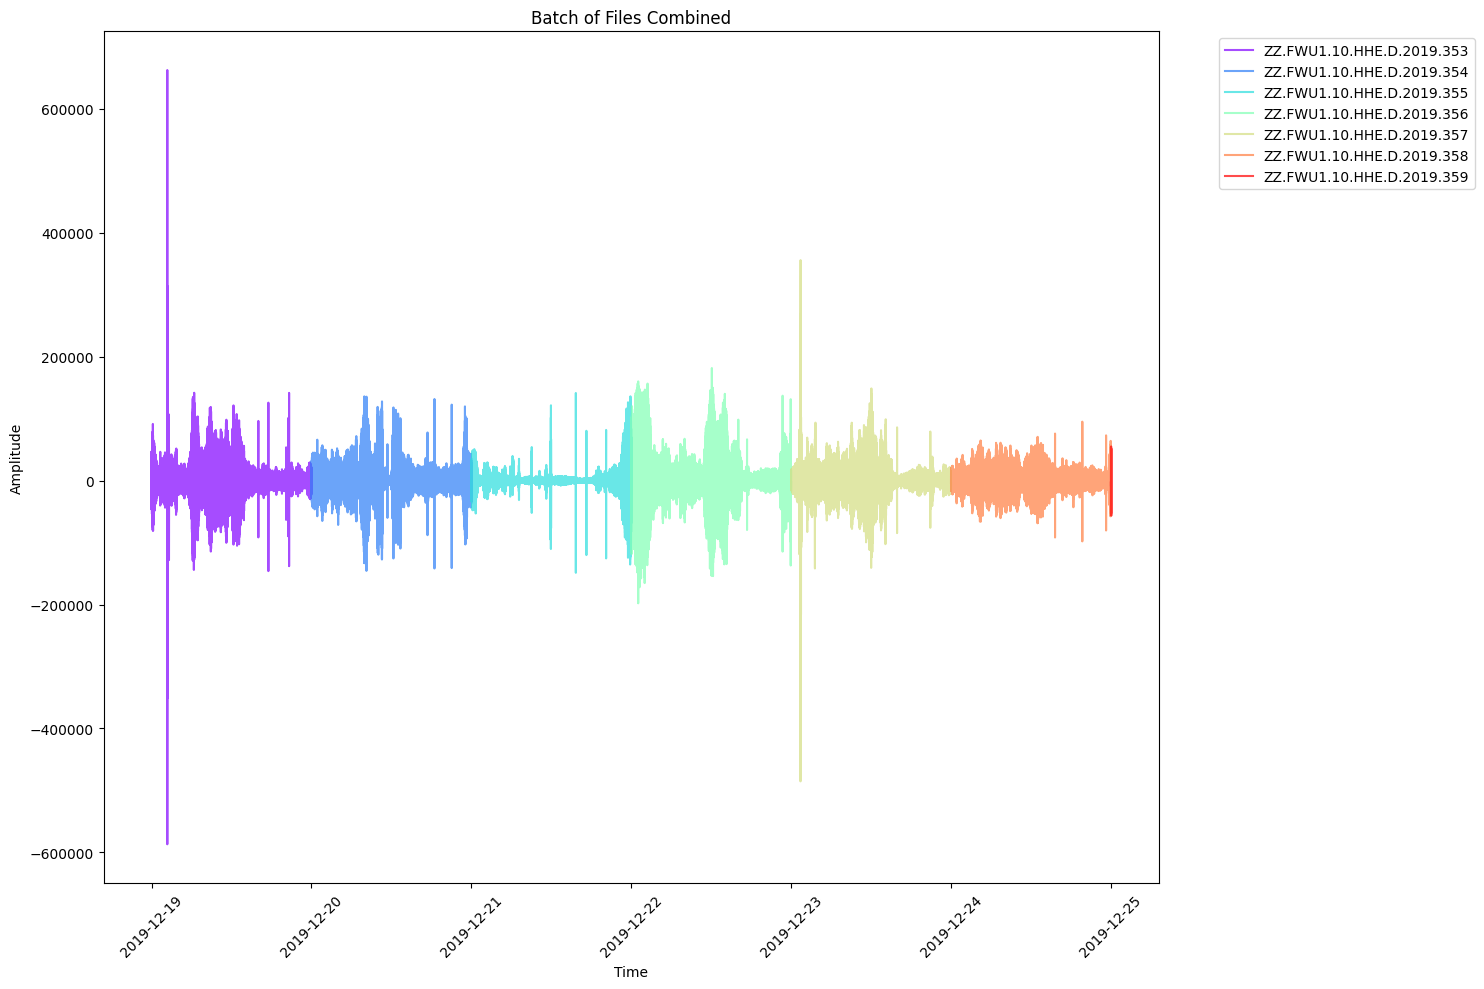

Processing complete.


In [ ]:
import os
import plotly.graph_objects as go
from obspy import read
import pandas as pd
import numpy as np
import dask.dataframe as dd
import gc
import psutil

def get_memory_usage():
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024  # in MB

def get_all_file_paths(directory):
    """Collects all file paths from the specified directory and returns a list of those paths."""
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

def read_file_to_dataframe(file_path):
    try:
        st = read(file_path)
        data = st[0].data
        start_time = st[0].stats.starttime
        sampling_rate = st[0].stats.sampling_rate
        time = pd.date_range(start=start_time.datetime, periods=len(data), freq=f'{1/sampling_rate}S')
        df = pd.DataFrame({'time': time, 'data': data, 'file': os.path.basename(file_path)})
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None

def plot_batch_data(fig, df, batch_number):
    # Compute unique files
    unique_files = df['file'].unique().compute()
    
    for file in unique_files:
        file_df = df[df['file'] == file].compute()
        fig.add_trace(go.Scatter(x=file_df['time'], y=file_df['data'], mode='lines', name=f"{file} (Batch {batch_number})"))

def main():
    directory = '/media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D'
    initial_batch_size =30
    max_memory_usage = 32000  # Adjust this based on your system's RAM (in MB)

    print(f"Getting all file paths from directory: {directory}")
    all_file_paths = get_all_file_paths(directory)

    print(f"Total files found: {len(all_file_paths)}")

    current_batch_size = initial_batch_size
    
    # Initialize the Plotly figure
    fig = go.Figure()
    fig.update_layout(title='Connected Batch Plots',
                      xaxis_title='Time',
                      yaxis_title='Amplitude',
                      height=600,
                      width=1000)

    for i in range(0, len(all_file_paths)):
        if i % current_batch_size == 0:
            batch_start = i
            print(f"\nProcessing batch {i//current_batch_size + 1} of {len(all_file_paths)//current_batch_size + 1}")

        file_path = all_file_paths[i]
        df = read_file_to_dataframe(file_path)
        if df is not None:
            if i == batch_start:
                batch_dfs = [df]
            else:
                batch_dfs.append(df)

            # Check memory usage
            mem_usage = get_memory_usage()
            if mem_usage > max_memory_usage:
                print(f"Memory usage exceeded ({mem_usage:.2f} MB). Processing current batch and adjusting batch size.")
                
                # Process current batch
                if len(batch_dfs) > 1:
                    ddf = dd.concat([dd.from_pandas(df, npartitions=1) for df in batch_dfs])
                    
                    print(f"Batch read. Total rows: {ddf.shape[0].compute()}")
                    print("Adding batch to plot...")
                    
                    # Add batch to the plot
                    plot_batch_data(fig, ddf, i//current_batch_size + 1)
                    
                    # Clear memory
                    del ddf
                    gc.collect()
                
                # Adjust batch size
                current_batch_size = max(1, current_batch_size // 2)
                print(f"Adjusted batch size to {current_batch_size}")
                
                # Reset batch
                batch_start = i + 1
                batch_dfs = []

        if i == len(all_file_paths) - 1 and len(batch_dfs) > 0:
            # Process the last batch if there are any remaining files
            ddf = dd.concat([dd.from_pandas(df, npartitions=1) for df in batch_dfs])
            
            print(f"Batch read. Total rows: {ddf.shape[0].compute()}")
            print("Adding final batch to plot...")
            
            # Add final batch to the plot
            plot_batch_data(fig, ddf, i//current_batch_size + 1)
            
            # Clear memory
            del ddf
            gc.collect()

    # Show the final plot
    fig.show()

    print("Processing complete.")

if __name__ == "__main__":
    main()

## Read Single File on (Enter)


Starting processing. Root directory: /media/rsbiim/Extreme Pro/ZZ_clean/FWU1/, Chunk size: 1000000

Processing file: /media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D/ZZ.FWU1.10.HHE.D.2019.304
File read successfully. Number of traces: 1
Processing chunk 1
DataFrame shape: (1000000, 2)
Creating plot: ZZ.FWU1.10.HHE.D.2019.304 - Chunk 1


/tmp/ipykernel_21264/1285540354.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time = pd.date_range(start=start_time.datetime, periods=len(chunk), freq=f'{1/sampling_rate}S')


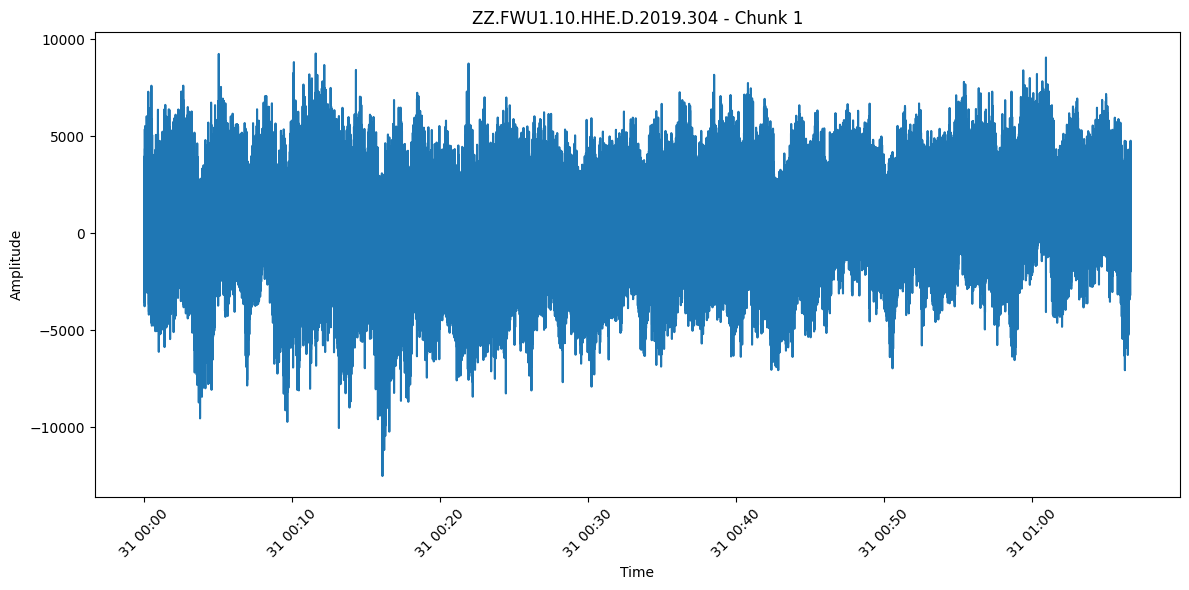

Plot displayed. Press Enter to continue...


In [ ]:
import os
import matplotlib.pyplot as plt
from obspy import read
import pandas as pd

def read_miniseed_to_dataframe(file_path, chunk_size=1000000):
    st = read(file_path)
    data = st[0].data
    start_time = st[0].stats.starttime
    sampling_rate = st[0].stats.sampling_rate
    
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i+chunk_size]
        time = pd.date_range(start=start_time.datetime, periods=len(chunk), freq=f'{1/sampling_rate}S')
        yield pd.DataFrame({'time': time, 'data': chunk})
        start_time += len(chunk) / sampling_rate

def plot_data(df, title=""):
    plt.figure(figsize=(12,6))
    plt.plot(df['time'], df['data'])
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def main():
    root_directory = '/media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D'
    chunk_size = 1000000  # Adjust this based on your memory constraints

    print(f"Starting processing. Root directory: {root_directory}, Chunk size: {chunk_size}")

    for dirpath, _, filenames in os.walk(root_directory):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)
            print(f"\nProcessing file: {file_path}")
            
            try:
                st = read(file_path)
                print(f"File read successfully. Number of traces: {len(st)}")
                
                for i, df in enumerate(read_miniseed_to_dataframe(file_path, chunk_size)):
                    print(f"Processing chunk {i+1}")
                    print(f"DataFrame shape: {df.shape}")
                    
                    title = f"{filename} - Chunk {i+1}"
                    print(f"Creating plot: {title}")
                    plot_data(df, title)
                    
                    print("Plot displayed. Press Enter to continue...")
                    
                    input()  # Wait for user input before continuing
                    
                    del df  # Clear the DataFrame to free up memory
            
            except Exception as e:
                print(f"Error processing file {file_path}: {str(e)}")

    print("Processing complete.")

if __name__ == "__main__":
    main()


In [ ]:
import os
import matplotlib.pyplot as plt
from obspy import read
import pandas as pd
import numpy as np

def get_all_file_paths(directory):
    """
    Collects all file paths from the specified directory and returns a list of those paths.
    """
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

def read_file_to_dataframe(file_path):
    try:
        st = read(file_path)
        data = st[0].data
        start_time = st[0].stats.starttime
        sampling_rate = st[0].stats.sampling_rate

        time = pd.date_range(start=start_time.datetime, periods=len(data), freq=f'{1/sampling_rate}S')
        df = pd.DataFrame({'time': time, 'data': data, 'file': os.path.basename(file_path)})
        return df
    except Exception as e:
        print(f"Error reading file {file_path}: {str(e)}")
        return None

def plot_batch_data(df):
    plt.figure(figsize=(15, 10))

    # Create a color map for different files
    unique_files = df['file'].unique()
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_files)))

    for file, color in zip(unique_files, colors):
        file_df = df[df['file'] == file]
        plt.plot(file_df['time'], file_df['data'], label=file, color=color, alpha=0.7)

    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Batch of Files Combined')
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

def main():
    directory = '/media/rsbiim/Extreme Pro/ZZ_clean/FWU1/HHE.D'
    batch_size = 20  # Adjust this based on your preference

    print(f"Getting all file paths from directory: {directory}")
    all_file_paths = get_all_file_paths(directory)

    print(f"Total files found: {len(all_file_paths)}")

    current_batch = []
    for i, file_path in enumerate(all_file_paths):
        print(f"\nProcessing file {i+1} of {len(all_file_paths)}")
        print(f"File: {file_path}")

        df = read_file_to_dataframe(file_path)
        if df is not None:
            print(f"File read. Total rows: {len(df)}")
            current_batch.append(df)

        if (i + 1) % batch_size == 0 or i == len(all_file_paths) - 1:
            if current_batch:
                batch_df = pd.concat(current_batch, ignore_index=True)
                print("Creating plot...")
                plot_batch_data(batch_df)
                del batch_df  # Clear the DataFrame to free up memory
                current_batch.clear()

    print("Processing complete.")

if __name__ == "__main__":
    main()